In [1]:
from mpes import fprocessing as fp, analysis as aly, visualization as vis
from symmetrize import sym, tps, pointops as po
import matplotlib.pyplot as plt
import numpy as np

### 3.1 Correction of symmetry distortion using thin plate spline
#### 3.1.0 Retrieve experimental data

In [2]:
fpath = r'../data/data_114_4axis_100x100x200x50.h5'
fbinned = fp.readBinnedhdf5(fpath)

In [3]:
V = fbinned['V']
V.shape

(50, 100, 100, 200)

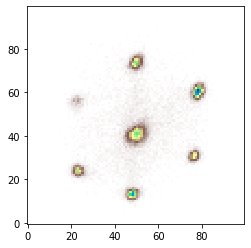

In [4]:
Eslice = V[15:20, :, :, 35:41].sum(axis=(0,3))
plt.imshow(Eslice, origin='lower', cmap='terrain_r')

In [5]:
mc = aly.MomentumCorrector(V[15:20, :, :, :].sum(axis=0), rotsym=6)

#### 3.1.1 Calculate coordinate deformation from selected or detected landmarks and their symmetric correspondences

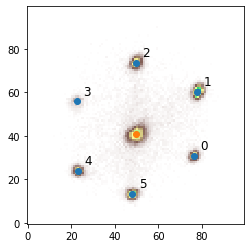

In [6]:
mc.selectSlice2D(selector=slice(35, 41), axis=2)
mc.featureExtract(image=mc.slice, method='daofind', sigma=5, fwhm=8)
mc.view(image=mc.slice, annotated=True, points=mc.features)

In [7]:
mc.ascale = np.array([1, 1, 1., 1., 1, 1., 1.])

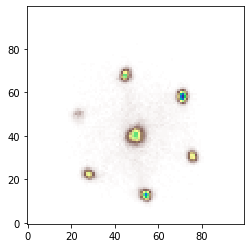

In [8]:
mc.ptargs = []
mc.splineWarpEstimate(image=mc.slice, landmarks=mc.pouter_ord, include_center=True, fixed_center=True,
                      iterative=False, interp_order=1, update=True)
mc.view(image=mc.slice_transformed)

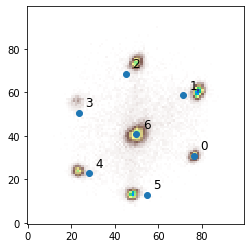

In [9]:
mc.view(image=mc.slice, annotated=True, points={'feats':mc.ptargs})

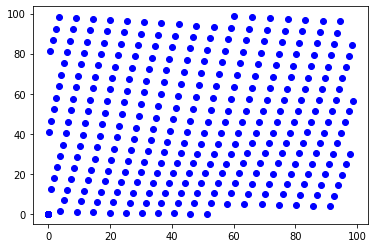

In [11]:
subs = 5 # Subsampling ratio
plt.scatter(mc.cdeform_field[::subs,::subs].ravel(), mc.rdeform_field[::subs,::subs].ravel(), c='b')

#### 3.1.2 Pose adjustment
Options to adjust scaling, rotation and translation, if needed. When the transform is desired, set `keep=True`

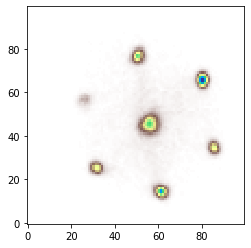

In [12]:
mc.coordinateTransform(image=mc.slice_transformed, type='scaling', xscale=1.13, yscale=1.13, keep=True)
mc.view(image=mc.slice_transformed)

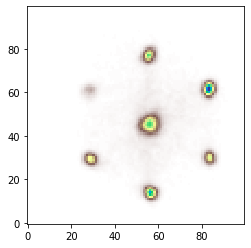

In [13]:
mc.coordinateTransform(image=mc.slice_transformed, type='rotation', angle=-9, center=(45, 55), keep=True)
mc.view(image=mc.slice_transformed)

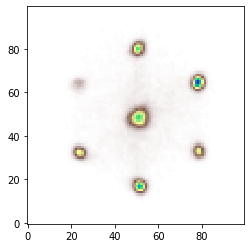

In [14]:
mc.coordinateTransform(image=mc.slice_transformed, type='translation', xtrans=-5, ytrans=3, keep=True)
mc.view(image=mc.slice_transformed)

#### 3.1.3 Apply deformation to all images in a stack

In [15]:
mc.correct(image=mc.image, axis=2, use_deform_field=True, update='image')

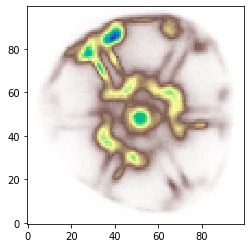

In [16]:
mc.view(image=mc.image[...,70:75].sum(axis=2), annotated=False)

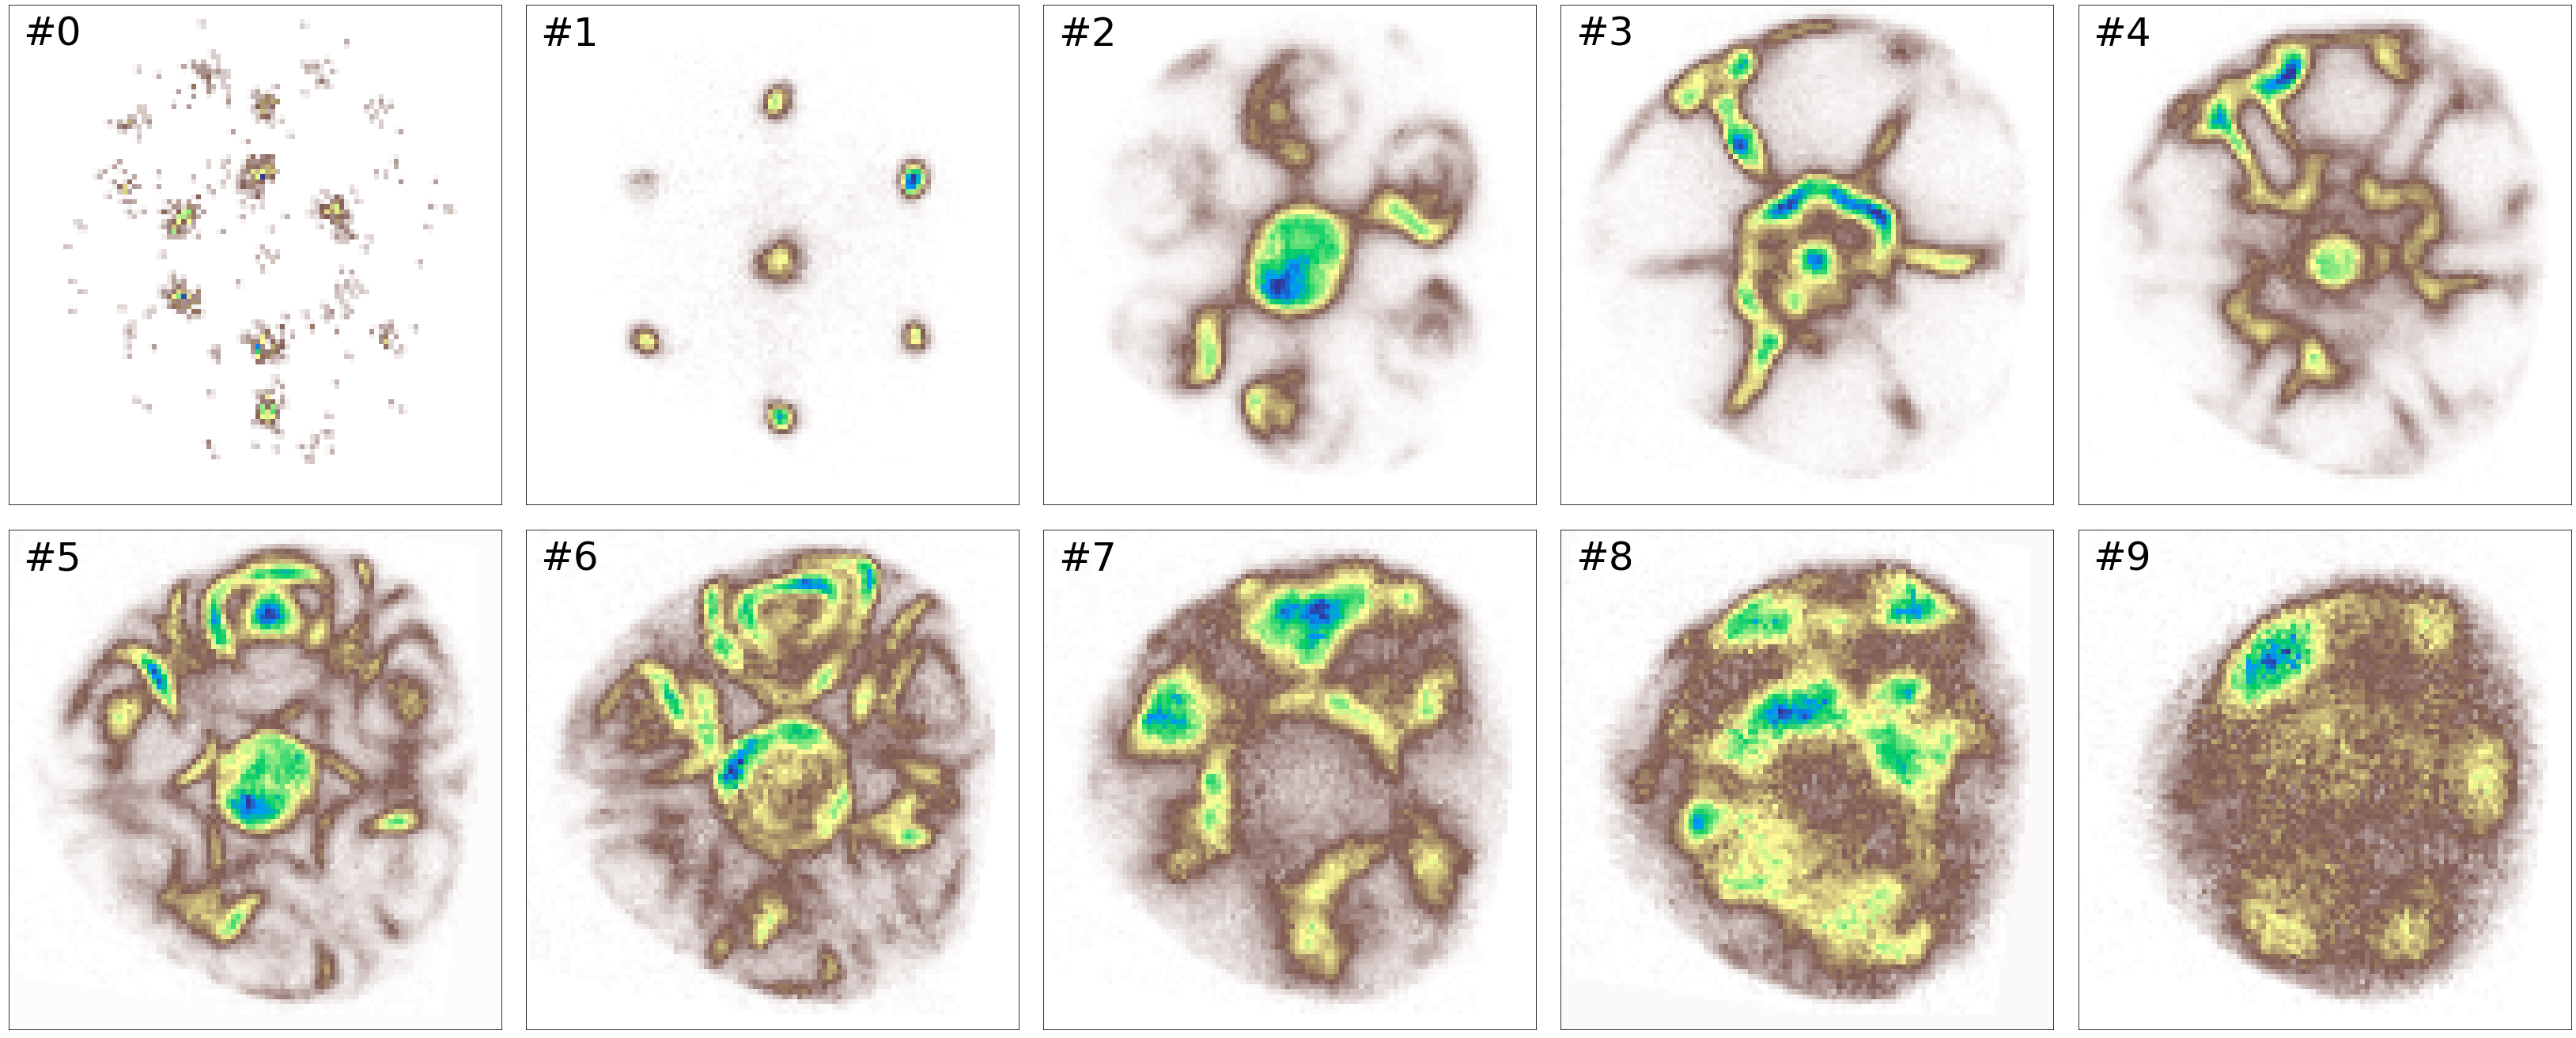

In [17]:
sliceid = [20, 40, 50, 65, 75, 90, 100, 120, 140, 180]
vis.sliceview3d(mc.image[...,sliceid], axis=2, ncol=5, colormap='terrain_r', numsize=50);

In [18]:
for i in range(50):
    fbinned['V'][i,...] = mc.correct(image=fbinned['V'][i,...], axis=2, use_deform_field=True)

In [19]:
from silx.io import dictdump
dictdump.dicttoh5(fbinned, '../data/data_114_4axis_corrected.h5')

### 3.2 Correct using manually selected landmarks

In [12]:
V = fp.readBinnedhdf5(fpath)['V']

In [13]:
mch = aly.MomentumCorrector(V[15:20, :, :, :].sum(axis=0), rotsym=3)

In [14]:
mch.selectSlice2D(selector=slice(35, 41), axis=2)

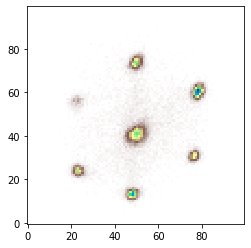

In [15]:
mch.view(mch.slice)

In [16]:
# Manually assign reference landmark positions, image center, and target landmark positions
mch.pouter_ord = np.array([[31, 74], [75, 49], [24, 22]]) # reference landmark positions 
mch.pcent = np.array([41, 50]) # center position
mch.ptargs = np.array([[31, 74], [75, 49], [24, 22]]) # target landmark positions

In [17]:
mch.rdeform_field = np.zeros_like(mch.slice)
mch.cdeform_field = np.zeros_like(mch.slice)

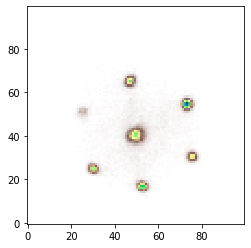

In [18]:
mch.splineWarpEstimate(image=mch.slice, landmarks=mch.pouter_ord, include_center=True, fixed_center=True,
                      iterative=False, interp_order=1, update=True)
mch.view(image=mch.slice_transformed)